# Plot yoda files

In [2]:
import yoda
import os
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.30/02


In [3]:
hist_name='d01-x01-y01'
data_hist_path = os.path.join(os.getcwd(), 
                              'rivet_histograms', 
                              'data', 
                              'ALEPH_1996_S3486095.yoda')
hist = yoda.read(data_hist_path)
hist_0=hist['/REF/ALEPH_1996_S3486095/d01-x01-y01']

In [4]:
hist_0.xVals()

array([0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275, 0.0325, 0.0375,
       0.045 , 0.055 , 0.07  , 0.09  , 0.11  , 0.14  , 0.18  , 0.225 ,
       0.275 , 0.325 , 0.375 , 0.45  , 0.55  , 0.65  , 0.75  ])

In [119]:
def get_hist(hist_name='d01-x01-y01', 
             hist_type='data', 
             hist_tree='ALEPH_1996_S3486095', verbose=False):

    if hist_type == 'data':
        yoda_filename = f'{hist_tree:s}.yoda'
        tree_name = f'/REF/{hist_tree:s}'
    else:
        yoda_filename = f'{hist_tree:s}_card_0.yoda'
        tree_name = f'/{hist_tree:s}'

    if verbose:
        print(f'hist name: {hist_name:s}\tyoda file: {yoda_filename:s}\t=> {hist_type:s}')
    
    hist_path = os.path.join(os.getcwd(), 
                             'rivet_histograms', 
                             hist_type, 
                             yoda_filename)
    yoda_file  = yoda.read(hist_path)
    
    full_hist_name = '%s/%s' % (tree_name, hist_name)
    if full_hist_name in yoda_file:
        yoda_hist  = yoda_file[full_hist_name]
        hist_edges = yoda_hist.xVals()
        hist_values= yoda_hist.yVals()
        hist_errors= yoda_hist.yErrs()
        if len(hist_errors.shape) > 1:
            hist_errors = hist_errors.sum(axis=1)/2
        return hist_edges, hist_values, hist_errors
    else:
        None

In [122]:
def print_hist(hdat, hsim=None):
    if hdat:
        print()    
        if hsim:
            edges, dat, errs = hdat
            _, sim, sim_errs = hsim
            print('%3s %10s %10s %10s %10s %10s' % ('bin', 'edge', 
                                                    'data', 'errs', 
                                                    'pred', 'errs'))
    
            for i, (edge, y, ye, t, te) in enumerate(zip(edges, dat, 
                                                         errs, sim, sim_errs)):
                print(f'{i+1:3d} {edge:10.4f} {y:10.4f} {ye:10.4f} {t:10.4f} {te:10.4f}')
        else:
            edges, counts, errs = hdat
            print('%3s %10s %10s %10s' % ('bin', 'edge', 'data', 'errs'))
    
            for i, (edge, y, ye) in enumerate(zip(edges, counts)):
                print(f'{i+1:3d} {edge:10.4f} {y:10.4f} {ye:10.4f}')

In [123]:
hdat = get_hist(hist_name='d01-x01-y01', 
                 hist_type='data', 
                 hist_tree='ALEPH_1996_S3486095')

hsim = get_hist(hist_name='d01-x01-y01', 
                 hist_type='simulation', 
                 hist_tree='ALEPH_1996_S3486095')

print_hist(hdat, hsim)


bin       edge       data       errs       pred       errs
  1     0.0025    12.3600     0.4079    11.8660     0.1541
  2     0.0075    23.3300     0.2550    23.6200     0.2173
  3     0.0125    20.2300     0.1562    20.7020     0.2035
  4     0.0175    16.6900     0.1204    17.1500     0.1852
  5     0.0225    13.4100     0.1000    13.7320     0.1657
  6     0.0275    10.7900     0.0990    11.1620     0.1494
  7     0.0325     8.8700     0.0940     9.0180     0.1343
  8     0.0375     7.4080     0.0892     7.5360     0.1228
  9     0.0450     5.9220     0.0693     6.0770     0.0780
 10     0.0550     4.5080     0.0526     4.4570     0.0668
 11     0.0700     3.2580     0.0305     3.3220     0.0408
 12     0.0900     2.3170     0.0233     2.2560     0.0336
 13     0.1100     1.7420     0.0227     1.7085     0.0292
 14     0.1400     1.2110     0.0184     1.1747     0.0171
 15     0.1800     0.8132     0.0152     0.7947     0.0141
 16     0.2250     0.5626     0.0127     0.5312     0.0

In [132]:
def chi2(data_hist, sim_hist, stdv, min_count=0.1):
    assert len(data_hist) == len(sim_hist)
    select = sim_hist > min_count
    y = data_hist[select]
    t = sim_hist[select]
    s = stdv[select]
    chi2 = ((y - t)/s)**2
    return chi2.sum(), len(y)-1

In [139]:
def get_hists(first=1, last=44):
    hists = []
    for i in range(first, last):
        
        name = 'd{:02d}-x01-y01'.format(i)
        hdat = get_hist(hist_name=name, 
                 hist_type='data', 
                 hist_tree='ALEPH_1996_S3486095')

        if hdat:
            edges, hdat, derrs = hdat
            
            hsim = get_hist(hist_name=name, 
                     hist_type='simulation', 
                     hist_tree='ALEPH_1996_S3486095')
            if hsim:
                _, hsim, serrs = hsim
                if len(hdat) != len(hsim):
                    print(f'\t** mismatch in bin counts\t\t** skipping: {name:s}')
                    continue
            else:
                print(f'\t** simulation {name:s} not found')
                continue
                
            total = hdat.sum()
            if total < 1:
                print(f'\t** sum(sim-counts)  < 1 \t\t** skipping: {name:s}')
                continue
    
            total = hsim.sum()
            if total < 1:
                print(f'\t** sum(data-counts) < 1 \t\t** skipping: {name:s}')
                continue

            # add "errors" in quadrature
            errs   = np.sqrt(derrs**2 + serrs**2)
            x, ndf = chi2(hdat, hsim, errs)
            if ndf > 1:
                print(f'name: {name:s}\tchi2 / NDF: {x:10.2f} / {ndf:d}')
            else:
                print(f'name: {name:s}\tchi2 / NDF: {x:10.2f} / {ndf:d}\t\t** skipping')
                continue
                
            hists.append((name, x, ndf, edges, hdat, hsim, errs))
        else:
            print(f'\t** data {name:s} not found')
    return hists

In [140]:
hists = get_hists()

name: d01-x01-y01	chi2 / NDF:      42.77 / 19
name: d02-x01-y01	chi2 / NDF:     109.78 / 11
name: d03-x01-y01	chi2 / NDF:      55.62 / 19
name: d04-x01-y01	chi2 / NDF:     138.29 / 12
name: d05-x01-y01	chi2 / NDF:       7.00 / 5
name: d06-x01-y01	chi2 / NDF:       7.40 / 18
name: d07-x01-y01	chi2 / NDF:      53.80 / 20
name: d08-x01-y01	chi2 / NDF:     126.44 / 15
name: d09-x01-y01	chi2 / NDF:     320.63 / 42
name: d10-x01-y01	chi2 / NDF:     247.06 / 18
name: d11-x01-y01	chi2 / NDF:     389.70 / 17
name: d12-x01-y01	chi2 / NDF:     922.30 / 12
	** simulation d13-x01-y01 not found
	** simulation d14-x01-y01 not found
	** simulation d15-x01-y01 not found
	** simulation d16-x01-y01 not found
name: d17-x01-y01	chi2 / NDF:     472.26 / 49
	** sum(data-counts) < 1 		** skipping: d18-x01-y01
name: d19-x01-y01	chi2 / NDF:       5.95 / 0		** skipping
name: d20-x01-y01	chi2 / NDF:       0.00 / 0		** skipping
name: d21-x01-y01	chi2 / NDF:       0.60 / 0		** skipping
name: d22-x01-y01	chi2 / NDF:

In [142]:
for name, x, ndf, edges, hdat, hsim, errs in hists:
    print(f'{name:s}\tchi2/ndf: {x/ndf:10.4f}')

d01-x01-y01	chi2/ndf:     2.2509
d02-x01-y01	chi2/ndf:     9.9797
d03-x01-y01	chi2/ndf:     2.9276
d04-x01-y01	chi2/ndf:    11.5244
d05-x01-y01	chi2/ndf:     1.4006
d06-x01-y01	chi2/ndf:     0.4112
d07-x01-y01	chi2/ndf:     2.6902
d08-x01-y01	chi2/ndf:     8.4294
d09-x01-y01	chi2/ndf:     7.6340
d10-x01-y01	chi2/ndf:    13.7256
d11-x01-y01	chi2/ndf:    22.9238
d12-x01-y01	chi2/ndf:    76.8583
d17-x01-y01	chi2/ndf:     9.6380
d25-x01-y01	chi2/ndf:    44.7196
d26-x01-y01	chi2/ndf:     3.2642
d27-x01-y01	chi2/ndf:     2.0011
d28-x01-y01	chi2/ndf:     0.7692
d29-x01-y01	chi2/ndf:     0.6687
d30-x01-y01	chi2/ndf:     3.1844
d32-x01-y01	chi2/ndf:     8.5289
d33-x01-y01	chi2/ndf:     3.2415
d34-x01-y01	chi2/ndf:     0.4924
d37-x01-y01	chi2/ndf:     1.8862
d38-x01-y01	chi2/ndf:     0.9393
d39-x01-y01	chi2/ndf:     2.3810
d40-x01-y01	chi2/ndf:     1.3050
d43-x01-y01	chi2/ndf:     0.6011


In [143]:
def plt_sim_data_hist(ax, hist):
    name, x, ndf, edges, hdat, hsim, errs = hist
    ax.step(y=hdat, x=edges, 
            label='data {}'.format(name), alpha=0.4)
    ax.step(y=hsim, x=edges, 
            label='simulation {}'.format(name), alpha=0.4)
    ax.legend()

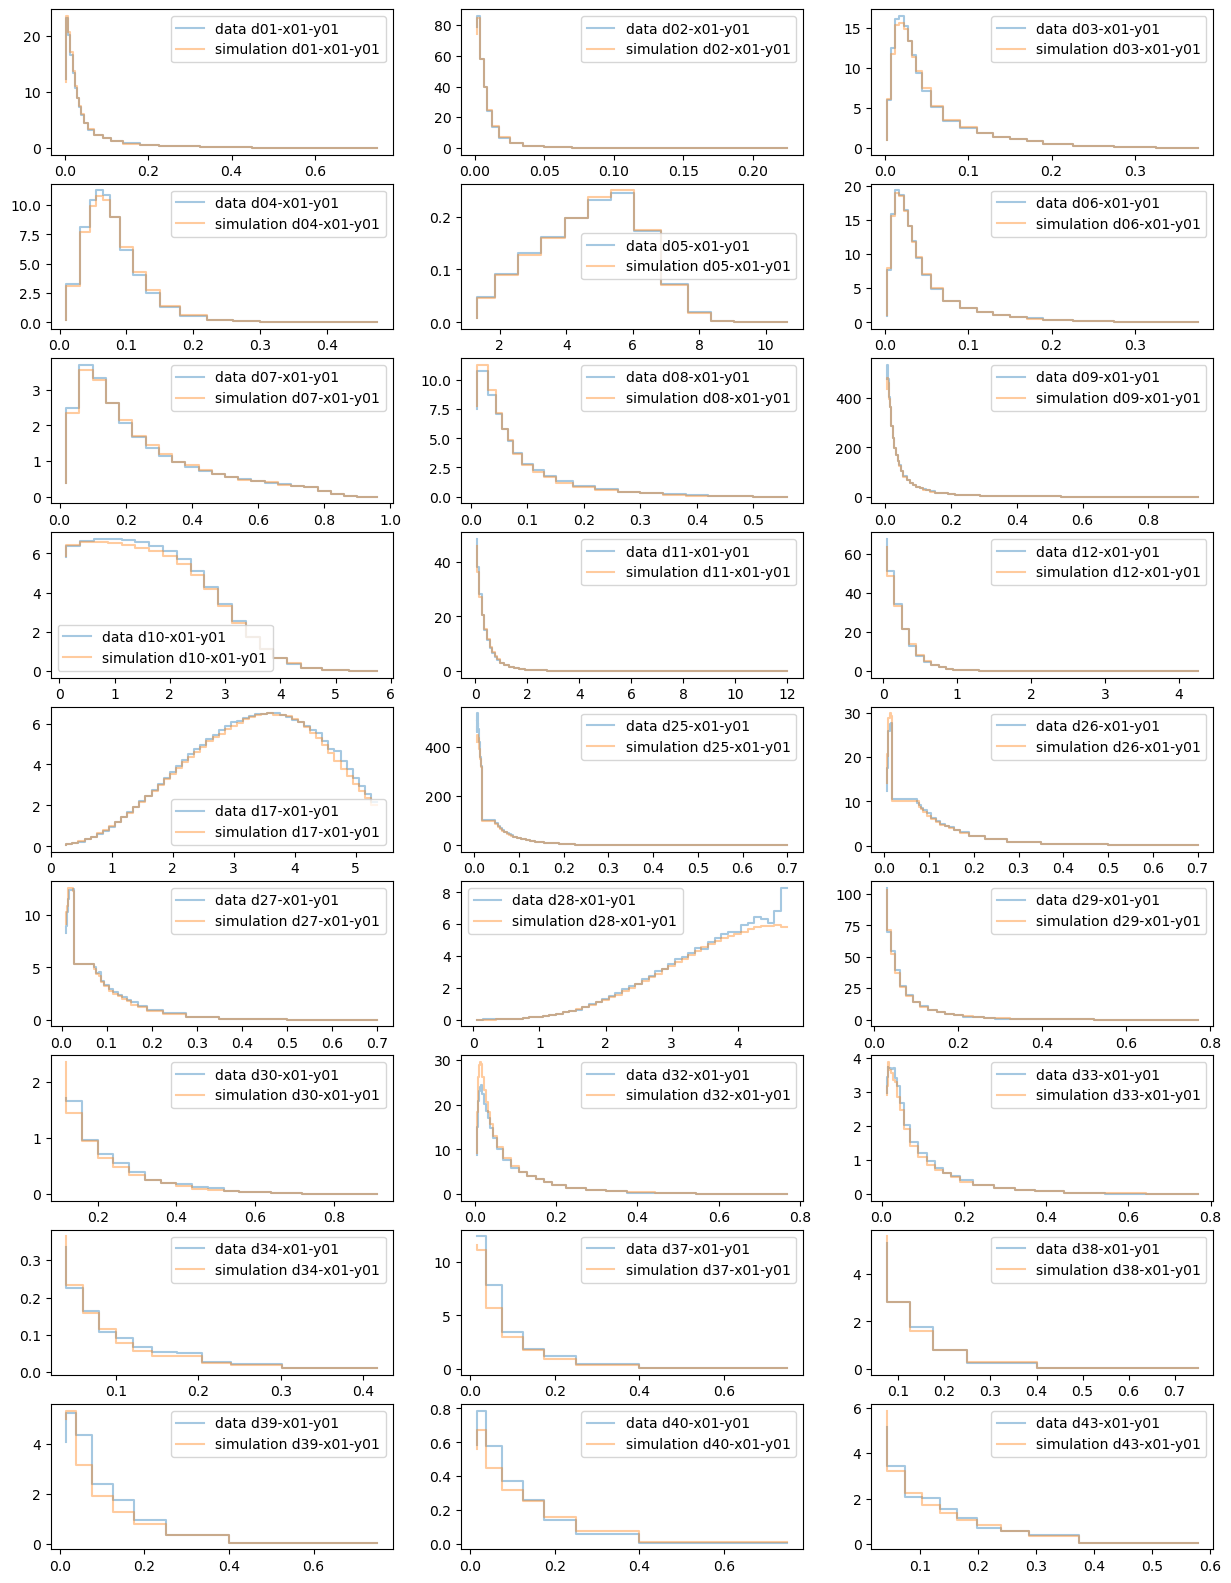

In [148]:
nrows=9; ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(15,20), edgecolor='k')
ax = ax.ravel()
for hist_ind, hist in enumerate(hists):
    plt_sim_data_hist(ax[hist_ind], hist)